## Marcenko-Pastur Theorem

In [9]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt

from sklearn.neighbors._kde import KernelDensity

In [10]:
def mp_pdf(sigma, T, N, pts):
    # Marcenko-Pastur PDF
    e_min = (sigma * (1 - np.sqrt(N / T)))**2
    e_max = (sigma * (1 + np.sqrt(N / T)))**2

    e_val = np.linspace(e_min, e_max, pts)

    pdf = (T / N) * np.sqrt((e_max - e_val) * (e_val - e_min)) / (2 * np.pi * e_val * sigma**2)
    
    pdf = pd.Series(pdf, index=e_val)

    return pdf

In [11]:
def get_pca(m):
    e_val, e_vec = np.linalg.eigh(m)
    idx = np.argsort(e_val)[::-1]
    e_val = e_val[idx]
    e_vec = e_vec[:, idx]
    e_val = np.diagflat(e_val)

    return e_val, e_vec

In [12]:
def fit_KDE(obs, b_width = .25, kernel = 'gaussian', x = None):
    # Fit kernel to a series of obs, and derive the probability of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1:
        obs = np.reshape(obs, (-1, 1))
    
    kde = KernelDensity(kernel=kernel, bandwidth=b_width).fit(obs)

    if x is None:
        x = np.unique(obs)
    if len(x.shape) == 1:
        x = np.reshape(x, (-1, 1))

    log_prob = kde.score_samples(x)

    pdf = pd.Series(np.exp(log_prob), index=x.flatten())

    return pdf

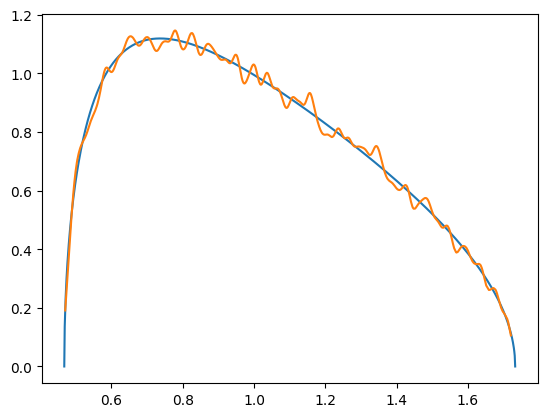

In [13]:
x = np.random.normal(size=(10000, 1000))
e_val0, e_vec0 = get_pca(np.corrcoef(x, rowvar=0))
pdf0 = mp_pdf(1., float(x.shape[0]), float(x.shape[1]), 1000)
pdf1 = fit_KDE(np.diag(e_val0), b_width=0.01)

plt.plot(pdf0)
plt.plot(pdf1)
plt.show()

## Denoising

In [14]:
def get_rand_cov(n, m):
    w = np.random.normal(size=(n, m))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size=n))
    return cov

In [15]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)

    # Numerical error
    corr[corr < -1] = -1
    corr[corr > 1] = 1

    return corr
    

In [16]:
def get_noisy_corr(alpha = .995, n = 1000, m = 100, q = 10):
    cov = np.cov(np.random.normal(size=(n * q, n)), rowvar=0)
    cov = alpha * cov + (1 - alpha) * get_rand_cov(n, m)
    corr = cov_to_corr(cov)
    e_val, e_vec = get_pca(corr)
    return e_val, e_vec

In [ ]:
def err_pdf(var, e_val, q, b_width, pts=1000):
    var = var[0]
    pdf0 = mp_pdf(var, q, pts) #theoretical pdf
    pdf1 = fit_KDE(e_val, b_width, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 

In [17]:
def findMaxEval(e_val, q, b_width):
    out = scipy.optimize.minimize(lambda *x: err_pdf(*x), x0=np.array(0.5), args=(e_val, q, b_width), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [18]:
def denoise_corr(e_val, e_vec, m):
    # Remove noise from corr by fixing random eigen values
    _e_val = np.diag(e_val).copy()
    _e_val[m:] = _e_val[m:].sum() / float(_e_val.shape[0] - m)
    _e_val = np.diag(_e_val)
    cov = np.dot(e_vec, _e_val).dot(e_vec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr = cov_to_corr(cov) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr


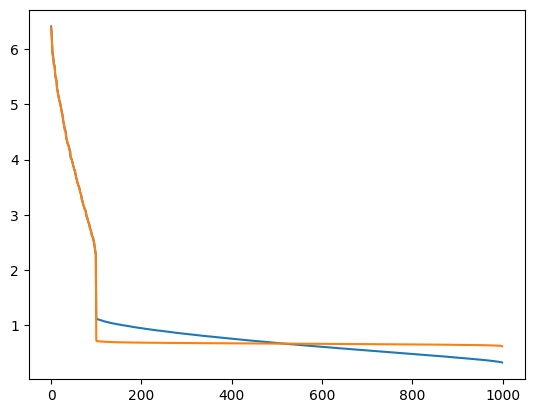

In [29]:
e_val, e_vec = get_noisy_corr()
e_val1, _ = get_pca(denoise_corr(e_val, e_vec, m=100))


plt.plot(np.diag(e_val))
plt.plot(np.diag(e_val1))
plt.show()